#  Walmart customer segmentation
Customer segmentation helps businesses group customers based on shopping behaviors to personalize marketing strategies, pricing, and product recommendations.
##  Objective
Customer segmentation helps businesses **group customers based on shopping behaviors** to personalize marketing strategies, pricing, and product recommendations.  
We will use **K-Means Clustering** to segment customers based on their spending and shopping preferences.

## Steps for Customer Segmentation

* Feature Selection – Choose relevant features for segmentation.
* Data Preprocessing – Clean and standardize the data.
* Exploratory Data Analysis (EDA) – Understand spending patterns.
* Apply Clustering Algorithms – K-Means, Hierarchical, or DBSCAN.
* Visualize Clusters – Interpret customer groups.
* Business Insights & Recommendations – Provide action points.


## 1️. Feature Selection
From the dataset, we can use the following features for segmentation:

- **`Purchase_Amount`** → Total amount spent.
- **`Category`** → Preferred product categories.
- **`Payment_Method`** → Preferred payment methods.
- **`Discount_Applied`** → Sensitivity to discounts.
- **`Repeat_Customer`** → New vs. returning customers.
- **`Age` & `Gender`** → Demographic information.

These features will help us cluster customers based on their **shopping habits, preferences, and spending behavior**.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# # Load dataset
df = pd.read_csv("C:/Users/hp/Desktop/Junior/mgs3101/Project/Walmart_customer_purchases.csv")  # Update the correct path
df.head()


,Customer_ID,Age,Gender,City,Category,Product_Name,Purchase_Date,Purchase_Amount,Payment_Method,Discount_Applied,Rating,Repeat_Customer
0,84607c1f-910c-44d5-b89f-e1ee06dd34c0,49,Female,New Cynthia,Electronics,Smartphone,2024/8/30,253.26,Cash on Delivery,No,1,Yes
1,f2a81712-a73e-4424-8b39-4c615a0bd4ea,36,Other,Cruzport,Clothing,T-Shirt,2024/12/21,73.19,Debit Card,Yes,1,No
2,da9be287-8b0e-4688-bccd-1a2cdd7567c6,52,Male,Jeffreytown,Beauty,Perfume,2024/12/26,125.62,Credit Card,Yes,1,No
3,50ec6932-3ac7-492f-9e55-4b148212f302,47,Female,Jenniferburgh,Electronics,Smartwatch,2024/11/4,450.32,Credit Card,No,2,Yes
4,8fdc3098-fc75-4b0f-983c-d8d8168c6362,43,Other,Kingshire,Electronics,Smartphone,2024/10/7,369.28,Credit Card,Yes,2,Yes


## 2. Exploratory Data Analysis (EDA)

Customer_ID         0
Age                 0
Gender              0
City                0
Category            0
Product_Name        0
Purchase_Date       0
Purchase_Amount     0
Payment_Method      0
Discount_Applied    0
Rating              0
Repeat_Customer     0
dtype: int64
---- Numeric summary ----


,Age,Purchase_Amount,Rating
count,2000.000000,2000.000000,2000.000000
mean,39.495500,257.854965,2.991000
std,12.560289,140.910224,1.401749
min,18.000000,10.420000,1.000000
25%,29.000000,136.907500,2.000000
50%,40.000000,255.555000,3.000000
75%,50.000000,384.082500,4.000000
max,60.000000,499.490000,5.000000



---- Categorical counts ----


Category
Clothing       512
Electronics    511
Home           501
Beauty         476
Name: count, dtype: int64

Payment_Method
UPI                 542
Cash on Delivery    494
Credit Card         493
Debit Card          471
Name: count, dtype: int64

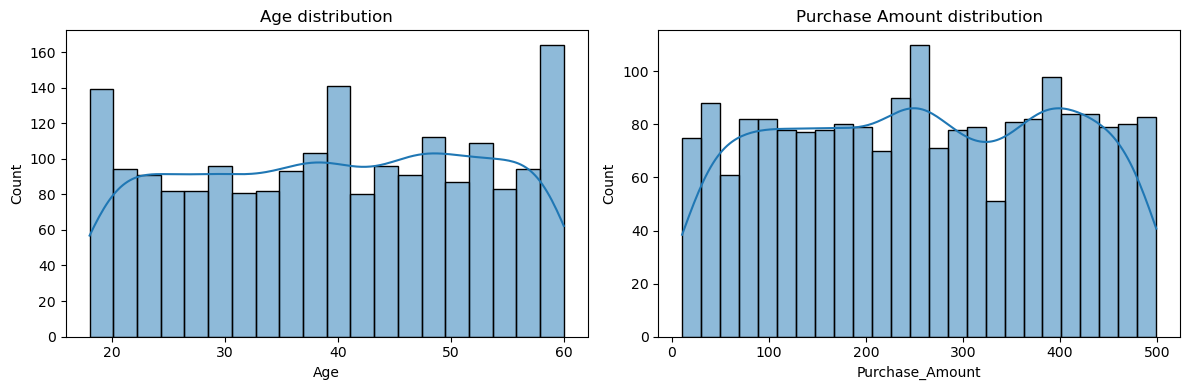

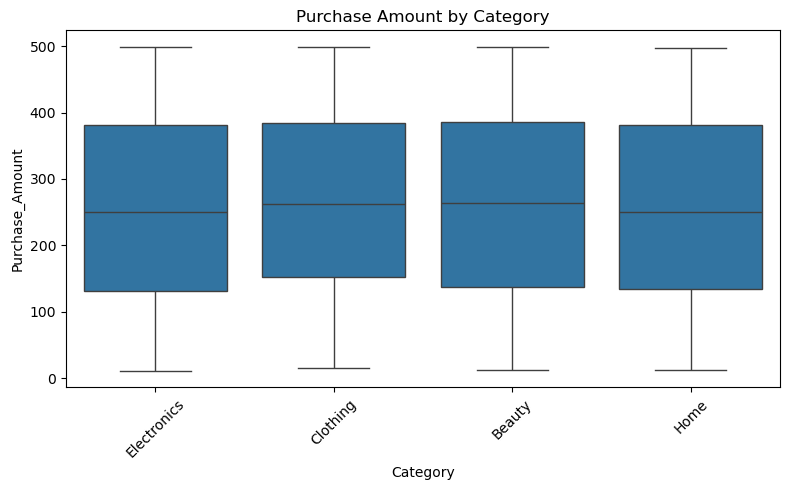

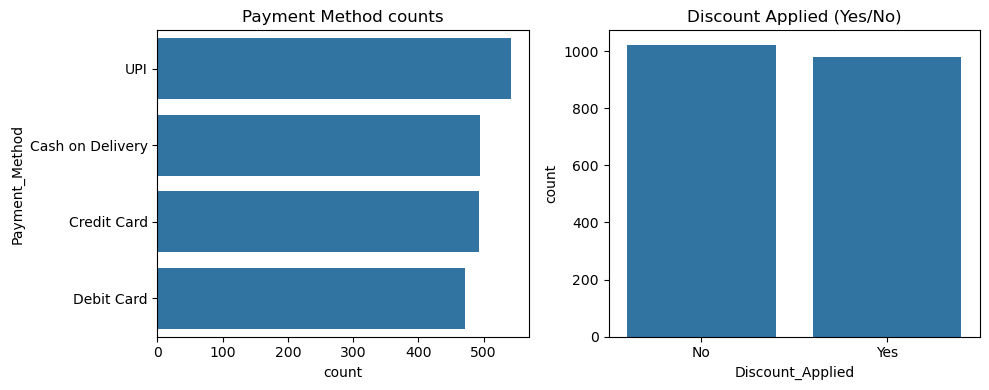

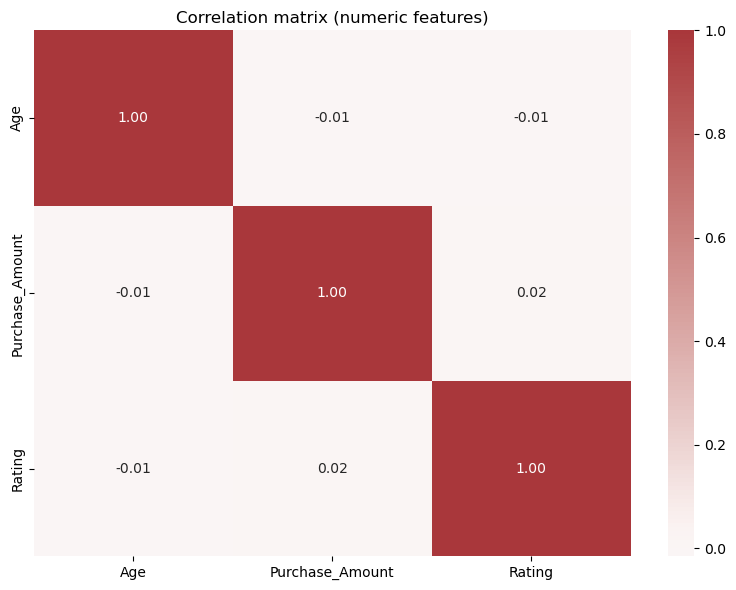

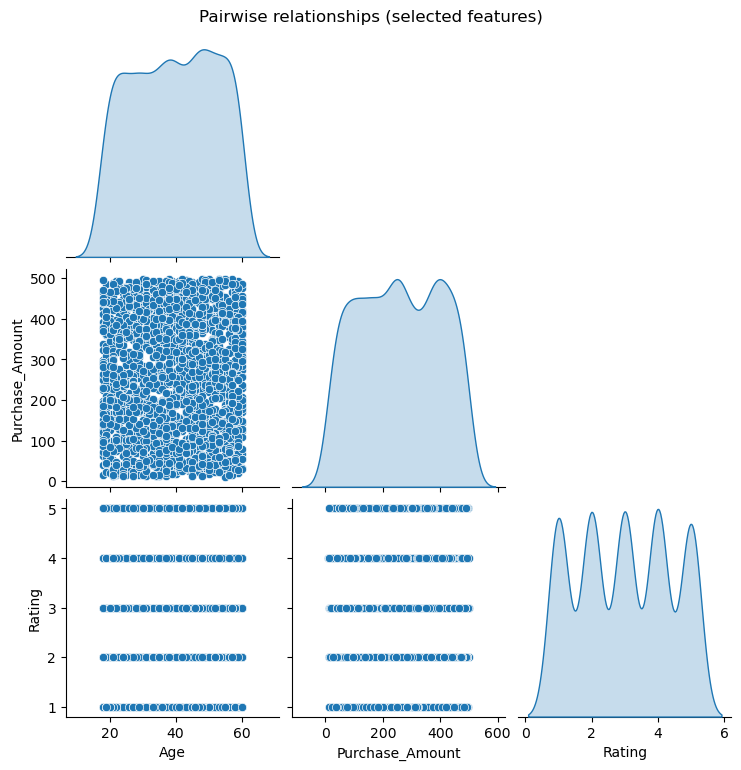

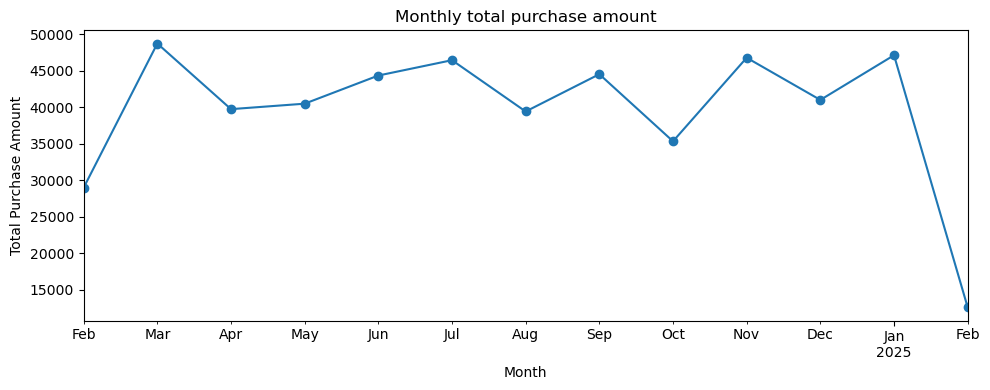

In [65]:
# Dropping the missing values.
df = df.dropna()    
df.count()
# Check for missing values
print(df.isnull().sum())
# ensure numeric Purchase_Amount (remove commas if any)
df['Purchase_Amount'] = pd.to_numeric(df['Purchase_Amount'].astype(str).str.replace(',',''), errors='coerce')

# Quick statistical summaries
print("---- Numeric summary ----")
display(df[['Age','Purchase_Amount','Rating']].describe())

print("\n---- Categorical counts ----")
display(df['Category'].value_counts())
display(df['Payment_Method'].value_counts())

# Distribution plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['Age'].dropna(), bins=20, kde=True)
plt.title('Age distribution')

plt.subplot(1,2,2)
sns.histplot(df['Purchase_Amount'].dropna(), bins=25, kde=True)
plt.title('Purchase Amount distribution')
plt.tight_layout()
plt.show()

# Boxplot: Purchase_Amount by Category
plt.figure(figsize=(8,5))
sns.boxplot(x='Category', y='Purchase_Amount', data=df)
plt.title('Purchase Amount by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plots: counts by Payment method and Discount
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(y='Payment_Method', data=df, order=df['Payment_Method'].value_counts().index)
plt.title('Payment Method counts')

plt.subplot(1,2,2)
sns.countplot(x='Discount_Applied', data=df)
plt.title('Discount Applied (Yes/No)')
plt.tight_layout()
plt.show()

# Correlation heatmap for numeric features (including encoded booleans if present)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Correlation matrix (numeric features)')
plt.tight_layout()
plt.show()

# Pairplot for selected features (may be slow for large datasets)
sns.pairplot(df[['Age','Purchase_Amount','Rating','Repeat_Customer']].dropna(), diag_kind='kde', corner=True)
plt.suptitle('Pairwise relationships (selected features)', y=1.02)
plt.show()

# Optional: examine monthly trends if Purchase_Date present
if 'Purchase_Date' in df.columns:
    try:
        df['Purchase_Date_parsed'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')
        df['Purchase_Month'] = df['Purchase_Date_parsed'].dt.to_period('M')
        monthly = df.groupby('Purchase_Month')['Purchase_Amount'].sum().dropna()
        plt.figure(figsize=(10,4))
        monthly.plot(marker='o')
        plt.title('Monthly total purchase amount')
        plt.xlabel('Month')
        plt.ylabel('Total Purchase Amount')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print("Purchase_Date parsing skipped:", e)


## 3. Predictive Analytics
Before clustering, we need to **clean and standardize** the data:

- Convert categorical features into numerical values.
- One-hot encode categorical columns (`Category`, `Payment_Method`).
- Scale numerical features (`Age`, `Purchase_Amount`, etc.) for better clustering.

Before clustering, we need to **clean and standardize** the data:

- Convert categorical features into numerical values.
- One-hot encode categorical columns (`Category`, `Payment_Method`).
- Scale numerical features (`Age`, `Purchase_Amount`, etc.) for better clustering.

In [66]:
# Convert categorical features to numerical values
df['Repeat_Customer'] = df['Repeat_Customer'].map({'Yes': 1, 'No': 0})
df['Discount_Applied'] = df['Discount_Applied'].map({'Yes': 1, 'No': 0})

# One-hot encode categorical features (Category & Payment Method)
df = pd.get_dummies(df, columns=['Category', 'Payment_Method'], drop_first=True)
print([col for col in df.columns if 'Category_' in col or 'Payment_Method_' in col])


# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['Age', 'Purchase_Amount', 'Discount_Applied', 'Repeat_Customer']])

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=['Age', 'Purchase_Amount', 'Discount_Applied', 'Repeat_Customer'])
df_scaled.head()

['Category_Clothing', 'Category_Electronics', 'Category_Home', 'Payment_Method_Credit Card', 'Payment_Method_Debit Card', 'Payment_Method_UPI']


,Age,Purchase_Amount,Discount_Applied,Repeat_Customer
0,0.756900,-0.032617,-0.978237,0.955968
1,-0.278367,-1.310843,1.022247,-1.046060
2,0.995807,-0.938669,1.022247,-1.046060
3,0.597628,1.366212,-0.978237,0.955968
4,0.279084,0.790950,1.022247,0.955968


## 3️.1 Finding the Optimal Number of Clusters
We use the Elbow Method to determine the best number of clusters for segmentation.

The Within-Cluster Sum of Squares (WCSS) is calculated for different cluster counts.
The "elbow point" on the plot indicates the optimal number of clusters (K)

e:\mgs\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
e:\mgs\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
e:\mgs\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
e:\mgs\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can a

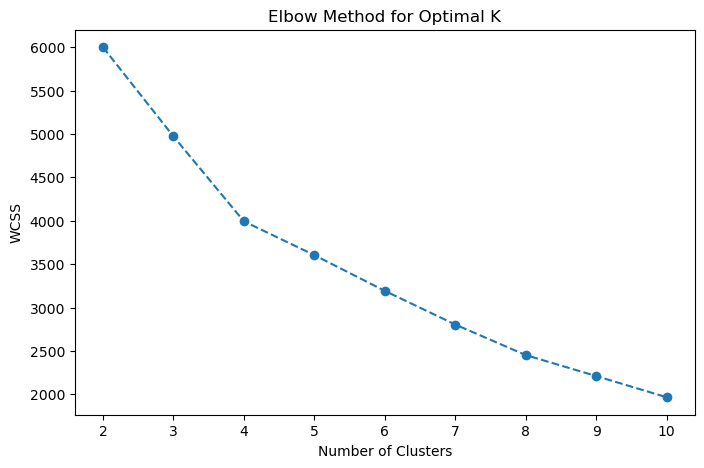

In [67]:
# Find optimal K using Elbow Method
wcss = []  # Within-Cluster Sum of Squares
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8,5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()


## 3.2 Apply K-Means Clustering

In [68]:
# Apply K-Means with optimal K
optimal_k = 4  # Choose based on elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_scaled['Cluster'] = kmeans.fit_predict(df_scaled)

# Merge cluster labels with original dataset
df['Cluster'] = df_scaled['Cluster']

# Display sample of customers with cluster labels
df[['Customer_ID', 'Age', 'Purchase_Amount', 'Cluster']].head()

e:\mgs\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


,Customer_ID,Age,Purchase_Amount,Cluster
0,84607c1f-910c-44d5-b89f-e1ee06dd34c0,49,253.26,2
1,f2a81712-a73e-4424-8b39-4c615a0bd4ea,36,73.19,3
2,da9be287-8b0e-4688-bccd-1a2cdd7567c6,52,125.62,3
3,50ec6932-3ac7-492f-9e55-4b148212f302,47,450.32,2
4,8fdc3098-fc75-4b0f-983c-d8d8168c6362,43,369.28,1


## 3.3 Visualizing Customer Segments

* PCA(n_components=2) initializes PCA to reduce the dataset to 2 principal components (PCA1 & PCA2).
* This converts the multi-dimensional dataset into a 2D space.

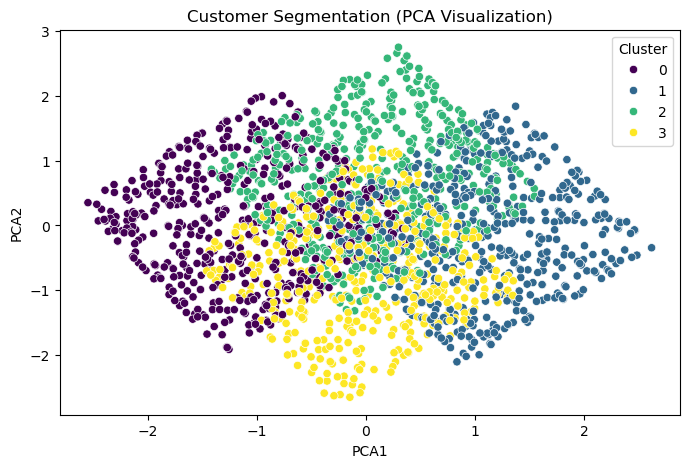

In [69]:
from sklearn.decomposition import PCA

# Reduce dimensions using PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_scaled.drop(columns=['Cluster']))

df_scaled['PCA1'] = pca_features[:,0]
df_scaled['PCA2'] = pca_features[:,1]

# Scatter plot of clusters
plt.figure(figsize=(8,5))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_scaled, palette='viridis')
plt.title('Customer Segmentation (PCA Visualization)')
plt.show()

This shows how customers are grouped into different segments based on their shopping behaviors.

In [70]:
cluster_summary = df.groupby('Cluster').mean(numeric_only=True)
print(cluster_summary)                                             

               Age  Purchase_Amount  Discount_Applied    Rating  \
Cluster                                                           
0        40.503055       259.771487               0.0  2.938900   
1        39.571984       251.403638               1.0  3.107004   
2        38.858757       261.150942               0.0  2.967985   
3        39.073276       259.201530               1.0  2.943966   

         Repeat_Customer  Category_Clothing  Category_Electronics  \
Cluster                                                             
0                    0.0           0.246436              0.240326   
1                    1.0           0.266537              0.231518   
2                    1.0           0.244821              0.286252   
3                    0.0           0.267241              0.262931   

         Category_Home  Payment_Method_Credit Card  Payment_Method_Debit Card  \
Cluster                                                                         
0             0.2464

### Customer Segmentation Characteristics

#### Cluster 0: High-Spending Repeat Customers
- Tend to spend a lot and shop frequently.
- Likely to be loyal customers.
- Respond well to exclusive loyalty rewards.

#### Cluster 1: Discount-Sensitive Shoppers 
- Highly responsive to discounts and promotions.
- May not spend as much without incentives.
- Targeted promotional emails can be effective.

#### Cluster 2: Budget-Conscious Shoppers 
- Prefer affordable products and bundles.
- May have limited spending capacity.
- Focus on value-for-money offerings.

#### Cluster 3: Occasional High-Spenders
- Spend significantly but less frequently.
- May require retargeting ads to maintain engagement.
- Potential for upselling during active shopping periods.

## 📊 Why Do We Use PCA Here?
* Data Visualization:
K-Means clustering works on high-dimensional data, but we can’t plot multiple dimensions easily.PCA reduces the data to 2D, allowing us to visualize clusters.
* Feature Reduction:
PCA removes redundant information while preserving important relationships.Helps in faster computation and better interpretation.


# 📊 Business Insights
1️⃣ **High-Spending Repeat Customers (Cluster 0)** → Offer exclusive loyalty rewards.  
2️⃣ **Discount-Sensitive Shoppers (Cluster 1)** → Target with promotional emails.  
3️⃣ **Budget-Conscious Shoppers (Cluster 2)** → Recommend affordable product bundles.  
4️⃣ **Occasional High-Spenders (Cluster 3)** → Use retargeting ads for engagement.  

## 💡 Business Recommendations:
- Use personalized discounts based on **customer spending behavior**.
- Implement **category-based recommendations** for specific segments.
- Optimize **payment methods** based on customer preferences.


## 4. Use K-Nearest Neighbors Algorithm to Predict New Customers

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

features = ['Age', 'Purchase_Amount', 'Discount_Applied', 'Repeat_Customer']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

df_scaled = df.copy()
df_scaled[features] = scaled_features

X = df_scaled[features]
y = df_scaled['Cluster']

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.3, random_state=42
)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': list(range(1, 21))}
grid = GridSearchCV(knn, param_grid, cv=5)
grid.fit(X_train, y_train)

best_k = grid.best_params_['n_neighbors']
print(f"Best k from CV: {best_k}")
print(f"Best CV score: {grid.best_score_:.3f}")

safe_k = max(best_k, 3)
print(f"Safe k for generalization: {safe_k}")
knn_final = KNeighborsClassifier(n_neighbors=safe_k)
knn_final.fit(X_train, y_train)

y_pred = knn_final.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Best k from CV: 1
Best CV score: 1.000
Safe k for generalization: 3
Confusion Matrix:
[[140   0   0   0]
 [  0 154   0   0]
 [  0   0 168   0]
 [  0   0   0 138]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00       154
           2       1.00      1.00      1.00       168
           3       1.00      1.00      1.00       138

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



#### Example

In [72]:
# 5. Predicting new customers (example)
new_customer = pd.DataFrame({
'Age': [30],
'Purchase_Amount': [250],
'Discount_Applied': [1],
'Repeat_Customer': [0]
})

new_scaled = scaler.transform(new_customer)
predicted_cluster = knn_final.predict(new_scaled)
print("🟦 New customer belongs to Cluster:", predicted_cluster[0])

🟦 New customer belongs to Cluster: 3


e:\mgs\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
